In [1]:
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import torch
import os
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors


# knn_model = KNeighborsClassifier(n_neighbors=1, metric='cosine')

In [2]:
def cosine_distance_torch(x1, x2=None):
    x2 = x1 if x2 is None else x2
    return torch.mm(x1.to(float), x2.t().to(float))

In [3]:
annot = np.load('../annotations/f1m/224_8shot_shifts.npy', allow_pickle=True).item()

In [4]:
annot.keys()

dict_keys(['images', 'categories'])

In [5]:
annot['images'];

In [6]:
# image_path = os.path.join('../images/f1m/224_8shot/train', annot['images'][0]['file_name'])
# print(image_path)
# image = cv2.imread(image_path)
# plt.imshow(image)


In [7]:
# image_path_shift_4 = os.path.join('../images/f1m/224_8shot_shift4/train', annot['images'][0]['file_name'])
# print(image_path_shift_4)
# image_shift_4 = cv2.imread(image_path_shift_4)
# plt.imshow(image_shift_4)


In [8]:
!ls ../embeddings/fair1m | grep 224

dino_224_8shot_blur2_embeddings.npy
dino_224_8shot_blur4_embeddings.npy
dino_224_8shot_blur6_embeddings.npy
dino_224_8shot_blur8_embeddings.npy
dino_224_8shot_embeddings.npy
dino_224_8shot_labels.npy
dino_224_8shot_map_from_rotated_10_to_original_idx.npy
dino_224_8shot_map_from_rotated_15_to_original_idx.npy
dino_224_8shot_map_from_rotated_20_to_original_idx.npy
dino_224_8shot_map_from_rotated_5_to_original_idx.npy
dino_224_8shot_map_from_scale_0_8_to_original_idx.npy
dino_224_8shot_map_from_scale_0_9_to_original_idx.npy
dino_224_8shot_map_from_scale_1_1_to_original_idx.npy
dino_224_8shot_map_from_scale_1_2_to_original_idx.npy
dino_224_8shot_noise_10_embeddings.npy
dino_224_8shot_noise_20_embeddings.npy
dino_224_8shot_noise_30_embeddings.npy
dino_224_8shot_noise_40_embeddings.npy
dino_224_8shot_rotate_10_embeddings.npy
dino_224_8shot_rotate_10_labels.npy
dino_224_8shot_rotate_15_embeddings.npy
dino_224_8shot_rotate_15_labels.npy
dino_224_8shot_rotate_20_embeddings.npy
dino_224_8shot_ro

# Load embeddings and labels

In [9]:
annot['categories'];

In [10]:
id_to_name = {cat['id']:cat['name'] for cat in annot['categories']}

In [11]:
finegrained_to_superclass = np.zeros(39, dtype=np.int32)
for i in range(1, 13):
    finegrained_to_superclass[i] = 1
for i in range(13, 22):
    finegrained_to_superclass[i] = 2
for i in range(22, 32):
    finegrained_to_superclass[i] = 3
for i in range(32, 36):
    finegrained_to_superclass[i] = 4
for i in range(36, 39):
    finegrained_to_superclass[i] = 5


In [12]:
models = ['sup_vit', 'dino', 'dinov2', 'mae', 'mae200']

# models = ['dino', 'ibot', 'dinov2']
transformations = [#'translation', 'blur', 'noise', 
    'rotate']
shifts = {}
shifts['translation'] = [1,2,3,4] # shift
shifts['blur'] = [2,4,6,8] # blur
shifts['noise'] = [10,20,30,40] # noise
shifts['rotate'] = [5, 10, 15, 20] # rotation angle
 
non_bg_counts = [7623 if model=='dinov2' else 5850 for model in models]


In [13]:
model_title = {
    'dino': "DINO",
    'dinov2': "DINOv2",
    'ibot':"iBOT",
    'sup_vit': "Supervised ViT",
    'mae': "MAE",
    'mae200': "MAE-200",
}

In [25]:
embeds = {}
labels = {}
label_ids = {model:{} for model in models}
for model in tqdm(models):
    labels[model] = torch.from_numpy(np.load(os.path.join(f'../embeddings/fair1m', f'{model}_224_8shot_labels.npy'), allow_pickle=True))
    embeds[model] = {}
    embeds[model]['translation'] = {
        0: torch.from_numpy(np.load(os.path.join(f'../embeddings/fair1m', 
                f'{model}_224_8shot_embeddings.npy'), allow_pickle=True))
    }
#     embeds[model]['blur'] = {0: embeds[model]['translation'][0]}
#     embeds[model]['noise'] = {0: embeds[model]['translation'][0]}
    embeds[model]['rotate'] = {0: embeds[model]['translation'][0]}
    
#     for shift in shifts['translation']:
#         embeds[model]['translation'][shift] = torch.from_numpy(np.load(os.path.join(f'../embeddings/fair1m', 
#                 f'{model}_224_8shot_shift{shift}_embeddings.npy'), allow_pickle=True))

#     for shift in shifts['blur']:
#         embeds[model]['blur'][shift] = torch.from_numpy(np.load(os.path.join(f'../embeddings/fair1m', 
#                 f'{model}_224_8shot_blur{shift}_embeddings.npy'), allow_pickle=True))
        
#     for shift in shifts['noise']:
#         embeds[model]['noise'][shift] = torch.from_numpy(np.load(os.path.join(f'../embeddings/fair1m', 
#                 f'{model}_224_8shot_noise_{shift}_embeddings.npy'), allow_pickle=True))
        
    for shift in shifts['rotate']:
        embeds[model]['rotate'][shift] = torch.from_numpy(np.load(os.path.join(f'../embeddings/fair1m', 
                f'{model}_224_8shot_rotate_{shift}_embeddings.npy'), allow_pickle=True))
        label_ids[model][shift] = torch.tensor(np.load(os.path.join('../embeddings/fair1m', 
                f'{model}_224_8shot_map_from_rotated_{shift}_to_original_idx.npy')))


  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
# for s in shifts['blur']:
#     print(f'mv ../embeddings/fair1m/ibot_224_8shot_blur_{s}_embeddings.npy ../embeddings/fair1m/ibot_224_8shot_blur{s}_embeddings.npy')

### the heavy calculation \/

In [28]:
matrices = {}

for mi, model in tqdm(enumerate(models), total=len(models)):
    print(f"\n{model}")    
    non_bg = labels[model] > 0
    
    matrices[model] = {}
    for ti, transformation in enumerate(transformations):
        matrices[model][transformation] = {}
        for shift in tqdm(shifts[transformation], leave=False):
            matrices[model][transformation][shift] = cosine_distance_torch(
                embeds[model][transformation][shift][non_bg], 
                embeds[model][transformation][0]
            )


  0%|          | 0/5 [00:00<?, ?it/s]


sup_vit


  0%|          | 0/4 [00:00<?, ?it/s]


dino


  0%|          | 0/4 [00:00<?, ?it/s]


dinov2


  0%|          | 0/4 [00:00<?, ?it/s]


mae


  0%|          | 0/4 [00:00<?, ?it/s]


mae200


  0%|          | 0/4 [00:00<?, ?it/s]

## Calculating the main scores 

In [17]:
shift

20

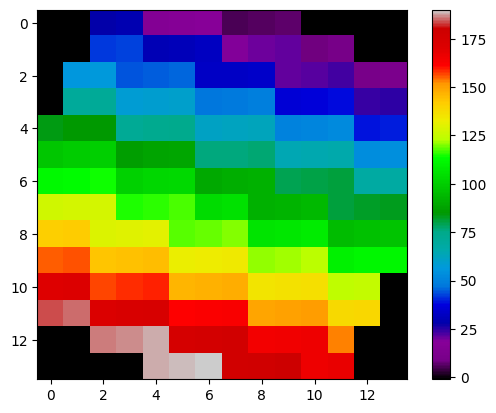

In [26]:
plt.figure()
plt.imshow(label_ids[model][20][0*196:1*196].reshape(14,14), cmap='nipy_spectral')
plt.colorbar()

In [19]:
raise Exception();

Exception: 

In [ ]:
plt.figure()
plt.imshow(label_ids[model][20][0*196:1*196].reshape(14,14), cmap='nipy_spectral')
plt.colorbar()

In [27]:
len(label_ids[model][shift])

57820

In [29]:
results = np.zeros((len(models), 3, len(shifts['blur']), 4+1))
cms = {}

for mi, model in tqdm(enumerate(models)):
    patch_count = (256 if model=='dinov2' else 196)

    cms[model] = {}
    total_patches = len(labels[model])
    non_bg = labels[model] > 0
    for ti, transformation in enumerate(transformations):
        print('\n', model, transformation)
        cms[model][transformation] = {}
        for si, shift in enumerate(shifts[transformation]):
            print(f"\nLevel: {shift}")
            closest_patch_id = matrices[model][transformation][shift].argmax(axis=1)

            correct_patch_id = label_ids[model][shift] + np.repeat(np.arange(len(label_ids[model][shift]) // patch_count),patch_count) * patch_count
            no_correct_patch = label_ids[model][shift] == -1
            
            no_correct_patch = non_bg.sum() - no_correct_patch[non_bg].sum()
            
            # same patch
            same_patch = np.equal(
                closest_patch_id,
                correct_patch_id[non_bg]
#                 np.arange(total_patches)[non_bg]
            ).sum()
            print(f"Same patch: {same_patch}")

            # same fine-grained category
            same_finegrained = np.equal(labels[model][non_bg], labels[model][closest_patch_id]).sum()
            print(f"Same fine grained category: {same_finegrained}")

            cms[model][transformation][shift] = metrics.confusion_matrix(labels[model][non_bg], labels[model][closest_patch_id], labels=np.arange(38))

            same_superclass = np.equal(
                finegrained_to_superclass[labels[model][non_bg]], 
                finegrained_to_superclass[labels[model][closest_patch_id]]
            ).sum()
            print(f"Same supercategory: {same_superclass}")

            results[mi][ti][si] = [same_patch, same_finegrained, same_superclass, 
                                    (finegrained_to_superclass[labels[model][closest_patch_id]] > 0).sum(), no_correct_patch]

#     matrices[model] = {}

0it [00:00, ?it/s]


 sup_vit rotate

Level: 5
Same patch: 1560
Same fine grained category: 4049
Same supercategory: 4285

Level: 10
Same patch: 390
Same fine grained category: 3200
Same supercategory: 3476

Level: 15
Same patch: 180
Same fine grained category: 2610
Same supercategory: 2999

Level: 20
Same patch: 91
Same fine grained category: 2207
Same supercategory: 2566

 dino rotate

Level: 5
Same patch: 2161
Same fine grained category: 4656
Same supercategory: 4793

Level: 10
Same patch: 541
Same fine grained category: 3646
Same supercategory: 3847

Level: 15
Same patch: 261
Same fine grained category: 3094
Same supercategory: 3355

Level: 20
Same patch: 134
Same fine grained category: 2633
Same supercategory: 2926

 dinov2 rotate

Level: 5
Same patch: 1527
Same fine grained category: 5585
Same supercategory: 5872

Level: 10
Same patch: 425
Same fine grained category: 4614
Same supercategory: 4935

Level: 15
Same patch: 205
Same fine grained category: 3937
Same supercategory: 4333

Level: 20
Same pat

In [30]:
metrics_ = ['Same patch', 'Same fine-grained cat.', 'Same supercategory', 'Non-background', 'Upper bound']

In [31]:
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ['lightblue', 'darkblue'])

In [32]:
non_bg_counts = [5850, 5850, 7623, 5850, 5850]
# non_bg_counts = [5850, 5850, 7623]

In [33]:
fs = 13

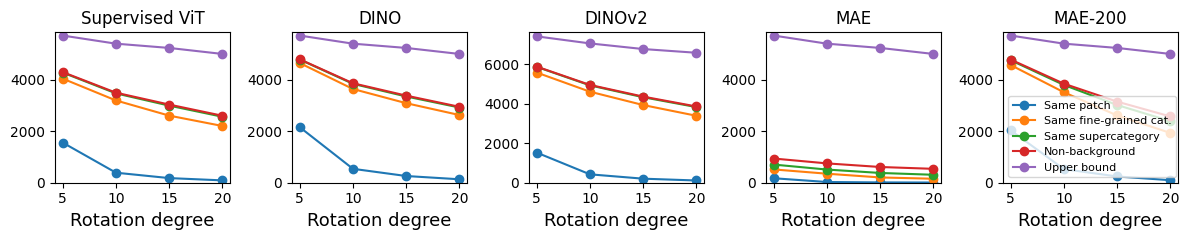

In [34]:
for ti, transformation in enumerate(transformations):
    fig, ax = plt.subplots(1, len(models), figsize=(12, 2.5))
    for mi, model in enumerate(models):
        mi_ = mi # 4 if mi == 0 else mi-1
        ax[mi].title.set_text(model_title[model])
        for k, metric in enumerate(metrics_): 
            ax[mi].plot(results[mi_, ti, :, k], label=metric, marker='o')
        ax[mi].set_xticks(range(0,4))
        
        if transformation == 'translation':
            ax[mi].set_xlabel("Shift in pixels", fontsize=fs)
            ax[mi].set_xticklabels(range(1, 5))
        elif transformation == 'blur':
            ax[mi].set_xlabel("Blur in pixels", fontsize=fs)
            ax[mi].set_xticklabels(np.arange(2, 9, 2))
        elif transformation == 'noise':
            ax[mi].set_xlabel("Noise std", fontsize=fs)
            ax[mi].set_xticklabels(np.arange(10, 41, 10))
        elif transformation == 'rotate':
            ax[mi].set_xlabel("Rotation degree", fontsize=fs)
            ax[mi].set_xticklabels(np.arange(5, 21, 5))

        ax[mi].set_ylim(0, non_bg_counts[mi_])
    plt.tight_layout();
    plt.savefig(f'./images/fair1m/fair1m-{transformation}s.pdf')

ax[mi].legend(fontsize=8);
plt.savefig(f'./images/fair1m/fair1m-{transformation}s.pdf')

# plt.savefig('./images/fair1m/')

In [ ]:
!mkdir ./images/fair1m

### What if we ask for the closest patch excluding the right one?

In [ ]:
matrices.keys()

In [ ]:
len(closest_patch_id)

In [ ]:
results_noself = np.zeros((len(models), len(transformations), len(shifts['blur']), 4))
for mi, model in tqdm(enumerate(models)):
    print(f"\n{model}")
    patch_count = (256 if model=='dinov2' else 196)
    print(matrices[model]['blur'][2].shape, embeds[model]['blur'][0].shape, labels[model].shape)

    non_bg = labels[model] > 0
    total_patches = len(labels[model])
    
    # disable same image
    image_ids = np.arange(len(non_bg)) // patch_count
    diag_mask = (image_ids[:, None] == image_ids[None, :])[non_bg]
    print("diag mask shape", diag_mask.shape)
    
    for ti, transformation in enumerate(transformations):
        print('\n', model, transformation)
#         cms[model][transformation] = {}
        for si, shift in enumerate(shifts[transformation]):
            print(f"\nShift: {shift}")
            tmp = matrices[model][transformation][shift].clone()
            tmp[diag_mask] = 0

            closest_patch_id = tmp.argmax(axis=1)
#             closest_patch_id = np.random.choice(range(total_patches), len(closest_patch_id))

            # same patch
            same_patch = np.equal(
                closest_patch_id,
                np.arange(total_patches)[non_bg]
            ).sum()
            print(f"Same patch: {same_patch}")

            # same image
            same_image = np.equal(
                closest_patch_id // patch_count,
                np.arange(total_patches)[non_bg] // patch_count
            ).sum()
            print(f"Same image: {same_image}")


            # same fine-grained category
            same_finegrained = np.equal(labels[model][non_bg], labels[model][closest_patch_id]).sum()
            print(f"Same fine grained category: {same_finegrained}")

    #         cms[model][shift] = metrics.confusion_matrix(labels[model][non_bg], labels[model][closest_patch_id[non_bg]], labels=np.arange(38))

            same_superclass = np.equal(
                finegrained_to_superclass[labels[model][non_bg]], 
                finegrained_to_superclass[labels[model][closest_patch_id]]
            ).sum()
            print(f"Same supercategory: {same_superclass}")

            some_class = (
                labels[model][closest_patch_id] > 0
            ).sum()
            print(f"Some object: {some_class}")

            bg = (
                labels[model][closest_patch_id] == 0
            ).sum()
            print(f"Background: {bg}")

            results_noself[mi, ti, si] = [same_finegrained, same_superclass, some_class, 0]
    
    

In [ ]:
metrics_noself = [
    'Same fine-grained cat.',
    'Same supercategory',
    'Any object category'
]

In [ ]:
for ti, transformation in enumerate(transformations):
    fig, ax = plt.subplots(1, len(models), figsize=(12, 2.5))
    for mi, model in enumerate(models):
        ax[mi].title.set_text(model_title[model])
        for k, metric in enumerate(metrics_noself): 
            ax[mi].plot(results_noself[mi, ti, :, k], label=metric, marker='o', color=f'C{k+1}')
        ax[mi].set_xticks(range(0,4))
        if transformation == 'translation':
            ax[mi].set_xlabel("Shift in pixels", fontsize=fs)
            ax[mi].set_xticklabels(range(1, 5))
        elif transformation == 'blur':
            ax[mi].set_xlabel("Blur in pixels", fontsize=fs)
            ax[mi].set_xticklabels(np.arange(2, 9, 2))
        elif transformation == 'noise':
            ax[mi].set_xlabel("Noise std", fontsize=fs)
            ax[mi].set_xticklabels(range(10, 41, 10))
            
        ax[mi].set_ylim(0, non_bg_counts[mi])
    ax[mi].legend()
    plt.tight_layout()
    plt.savefig(f'./images/fair1m/fair1m-retrieval-{transformation}.pdf')

In [ ]:
exit